In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
print(torch.__version__)
import torchvision
from torchvision import transforms
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
import time
import torchvision.models as models
import easydict
import os, sys, numpy as np
import argparse
from time import time
from tqdm import tqdm

import tensorflow # needs to call tensorflow before torch, otherwise crush
import torch
import torch.nn as nn
from torch.autograd import Variable

gpu_boole = torch.cuda.is_available()
print('GPU is on :', torch.cuda.is_available())

# Sleep for a few seconds.


# Play an audio beep. Any audio URL will do.
from google.colab import output
#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

1.8.1+cu101
GPU is on : True


In [ ]:
# if using colab
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data preprocess

In [ ]:
transform = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/train', transform=transform)
#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 3450
    Root location: gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
           )

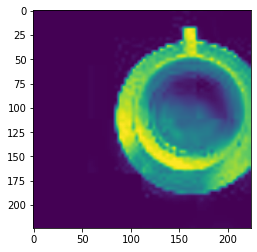

In [ ]:
plt.imshow(dataset[0][0][0])

In [ ]:
torch.manual_seed(17)
N = len(dataset)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [int(0.8*N), int(0.1*N), int(0.1*N)])
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
for image,label in train_loader:
  print(image.shape,label.shape)
  break

torch.Size([32, 3, 224, 224]) torch.Size([32])


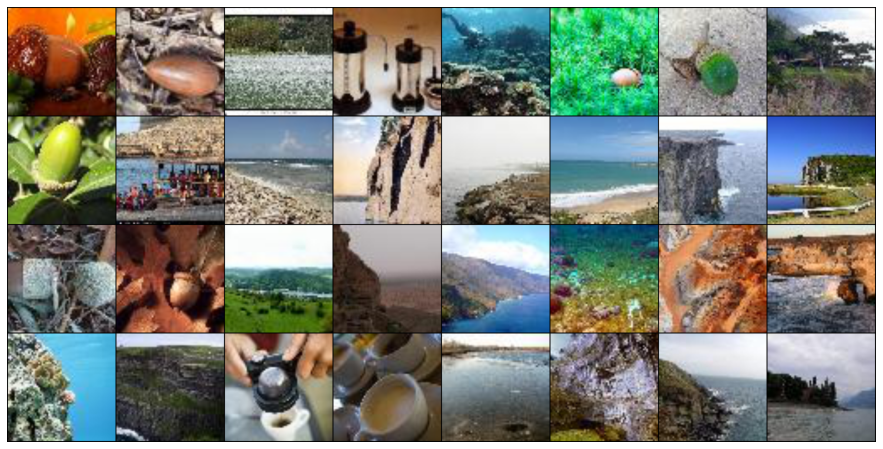

In [ ]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

加粗文字# Github

### ImageDataLoader

### Jigsaw_ImageLoader

In [ ]:
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image


class DataLoader(data.Dataset):
    def __init__(self, data_path, txt_list, classes=1000):
        self.data_path = data_path
        self.names, _ = self.__dataset_info(txt_list)
        self.N = len(self.names)
        self.permutations = self.__retrive_permutations(classes)

        self.__image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.Lambda(rgb_jittering),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            # std =[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        framename = self.data_path + '/' + self.names[index]
        #print()
        #isExist = os.path.exists(framename)

        img = Image.open(framename).convert('RGB')
        # print('get item')
        # print(plt.imshow(img))
        #img = img.convert('RGB')
        if np.random.rand() < 0.30:
            #img = img.convert('LA').convert('RGB')
            img = img

        if img.size[0] != 255:
            img = self.__image_transformer(img)

        s = (img.size[0]) / 3
        a = s / 2
        tiles = [None] * 9

        n = 0
        for i in range(3):
          for j in range(3):

            c = np.array([i*85,j*85,i*85+85,j*85+85]).astype(int)
  
            tile = img.crop(c.tolist())

            tile = self.__augment_tile(tile)

            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            #tile = norm(tile)

            tiles[n] = tile
            n+=1

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(9)]
        data = torch.stack(data, 0)

        return data, int(order), tiles

    def __len__(self):
        return len(self.names)

    def __dataset_info(self,txt_labels): #改
        #txt_labels = self.txt_list #txtpath
        with open(txt_labels, 'r') as f:
            images_list = f.readlines()

        file_names = []
        labels = []
        for row in images_list:
          #print(row)

          row = row.rstrip('\n').split('\t')
          # print(row[0])
          # print(row[1])
          file_names.append(row[0])
          labels.append((row[1]))

        return file_names, labels 


    def __retrive_permutations(self, classes):
        all_perm = np.load('gdrive/MyDrive/permutations_%d.npy' % (classes))
        # from range [1,9] to [0,8]
        if all_perm.min() == 1:
            all_perm = all_perm - 1

        return all_perm


def rgb_jittering(im):
    im = np.array(im, 'int32')
    for ch in range(3):
        im[:, :, ch] += np.random.randint(-2, 2)
    im[im > 255] = 255
    im[im < 0] = 0
    return im.astype('uint8')


In [ ]:
perms = np.load('gdrive/MyDrive/permutations_1000.npy')
perms

array([[5, 8, 6, ..., 7, 3, 0],
       [3, 0, 2, ..., 1, 5, 8],
       [0, 1, 4, ..., 8, 7, 2],
       ...,
       [6, 4, 1, ..., 7, 5, 0],
       [4, 3, 6, ..., 7, 1, 0],
       [4, 5, 2, ..., 1, 7, 8]])

In [ ]:
# for img, label, in train_data:
#   print(img,label)
#   break
# plt.imshow(train_data[0][0][0][0])

In [ ]:
# data = 'gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/'
# # trainpath = data + '/train'
# trainpath = data + 'train/n09246464/images'
# txtpath = data+'/train/n09246464/n09246464_boxes.txt'
# print(trainpath)
# #if os.path.exists(trainpath+'_255x255'):
#     #trainpath += '_255x255'
# train_data = DataLoader(trainpath , txtpath)

In [ ]:
#ls gdrive/MyDrive/Colab\ Notebooks/deep\ learning/final/small-tiny-imagenet-200/train/n09246464/images

## Utils

### Layers - class LRN

In [ ]:
"""
https://github.com/jiecaoyu/pytorch_imagenet/blob/master/networks/model_list/alexnet.py
"""
import torch.nn as nn

class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

### TrainingUtils - LR + Accuracy

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr=0.1, step=30, decay=0.1):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (decay ** (epoch // step))
    print('Learning Rate %f'%lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def compute_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import scipy.misc 
try:
    from io import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step)
            self.writer.flush()
        # summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        # self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            Image.fromarray(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

### visualization

In [ ]:
def visualization(data,permutation_list,true_perm_index,pred_perm_index,image_size = (3,255,255)):
# data: 9x3xWidthxHeight, one 9 tile image data
# permutation_list: 9x1000, the list to all permuations
# true_perm_index: int, index of the permutation
# pred_perm_index: int, index of predicted permuation


  true_label = permutation_list[true_perm_index]
  pred_label = permutation_list[pred_perm_index]

  
  data_array = data
  pred_data = [data_array[pred_label==i] for i in range(9)]
  truth_data = [data_array[true_label==i] for i in range(9)]
  width, height = image_size[1]/3,image_size[2]/3
  image_size = image_size

  
  img_data = torch.zeros(image_size)
  img_truth = torch.zeros(image_size)
  img_pred = torch.zeros(image_size)
  index = 0
  for i in range(3):
    for j in range(3):

      w = int(width * j)
      h = int(height * i)
      img_data[:,w:w+75,h:h+75] = data_array[index]
      img_truth[:,w:w+75,h:h+75] = truth_data[index]
      img_pred[:,w:w+75,h:h+75] = pred_data[index]
      index += 1
  dtp = (np.transpose(img_data, (1, 2, 0)),np.transpose(img_truth, (1, 2, 0)),np.transpose(img_pred, (1, 2, 0)))

  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
  title = ('data','truth {}: {}'.format(true_perm_index,true_label),'prediction {}: {}'.format(pred_perm_index,pred_label))
  for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(dtp[i], cmap=plt.cm.jet)

      plt.title(title[i])
  plt.show()




# JigsawNetwork

In [ ]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

import sys
#sys.path.append('Utils')
#from Layers import LRN

class Network(nn.Module):

    def __init__(self, classes=1000):
        super(Network, self).__init__()
 
        self.conv = nn.Sequential()
        self.conv.add_module('conv1_s1',nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn1_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv2_s1',nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn2_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv3_s1',nn.Conv2d(256, 384, kernel_size=3, padding=1))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv4_s1',nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu4_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv5_s1',nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu5_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool5_s1',nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*3*3, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        
        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)
    
    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal(model.weight.data)
        nn.init.constant(model.bias.data, 0.1)
    


## JigsawTrain

In [ ]:
args = easydict.EasyDict({'data': 'gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/',
        'model':None,
        'classes':1000,
        'gpu' : 1,
        'epochs' : 1,
        'iter_start' : 0,
        'batch' : 100,
        'lr' : 0.01,
        'cores' : 0,
        'checkpoint' : 'ss',  
        'evaluate' : 0
        })


criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()

trainpath =  'train/n07920052/images'
txtpath = 'train/n07920052/n07920052_boxes.txt'

valpath = 'train/n09256479/images'
val_txtpath = '/train/n09256479/n09256479_boxes.txt'

if args.gpu is not None:
  print(('Using GPU %d'%args.gpu))
  os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
  os.environ["CUDA_VISIBLE_DEVICES"]=str(args.gpu)
else:
  print('CPU mode')

print('Process number: %d'%(os.getpid()))

## DataLoader initialize ILSVRC2012_train_processed
#trainpath = args.data+'/ILSVRC2012_img_train'
#trainpath = args.data
if os.path.exists(trainpath+'_255x255'):
  trainpath += '_255x255'
# train_data = DataLoader(trainpath,args.data+'/ilsvrc12_train.txt',
#                         classes=args.classes)

train_data = DataLoader(args.data + trainpath,args.data + txtpath,
                      classes=args.classes) 

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                    batch_size=args.batch,
                    shuffle=True,
                    num_workers=args.cores)
if os.path.exists(valpath+'_255x255'):
  valpath += '_255x255'
val_data = DataLoader(args.data + valpath, args.data + val_txtpath,
                      classes=args.classes)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                      batch_size=args.batch,
                                      shuffle=True,
                                      num_workers=args.cores)
N = train_data.N

iter_per_epoch = train_data.N/args.batch
print('Images: train %d, validation %d'%(train_data.N,val_data.N))

net = Network(args.classes)
if args.gpu is not None:
    net.cuda()

#force break
############## Load from checkpoint if exists, otherwise from model ###############
if os.path.exists(args.checkpoint):
  files = [f for f in os.listdir(args.checkpoint) if 'pth' in f]
  if len(files)>0:
      files.sort()
      #print files
      ckp = files[-1]
      net.load_state_dict(torch.load(args.checkpoint+'/'+ckp))
      args.iter_start = int(ckp.split(".")[-3].split("_")[-1])
      print('Starting from: ',ckp)
  else:
      if args.model is not None:
          net.load(args.model)
else:
  if args.model is not None:
      net.load(args.model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=args.lr,momentum=0.9,weight_decay = 5e-4)


#logger_test = None

############## TESTING ###############
if args.evaluate:
  test(net,criterion,None,val_loader,0)
  #return

############## TRAINING ###############
print(('Start training: lr %f, batch size %d, classes %d'%(args.lr,args.batch,args.classes)))
print(('Checkpoint: '+args.checkpoint))

# Train the Model
batch_time, net_time = [], []
steps = args.iter_start

lr = args.lr


for epoch in range(int(args.iter_start/iter_per_epoch),args.epochs):
  if epoch%10==0 and epoch>0:
      test(net,criterion,logger_test,val_loader,steps)
      lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.1)
  
  end = time()
  for i, (images, labels, original) in enumerate(train_loader):
      batch_time.append(time()-end)
      if len(batch_time)>100:
          del batch_time[0]
      
      images = Variable(images)
      labels = Variable(labels)
      if args.gpu is not None:
          images = images.cuda()
          labels = labels.cuda()

      # Forward + Backward + Optimize
      optimizer.zero_grad()
      t = time()
      outputs = net(images)
      net_time.append(time()-t)
      if len(net_time)>100:
          del net_time[0]
      
      prec1, prec5 = compute_accuracy(outputs.cpu().data, labels.cpu().data, topk=(1, 5))
      #acc = prec1[0]
      acc = prec1.item()
      #print(outputs,labels)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      loss = float(loss.cpu().data.numpy())

      if steps%4==0:
          print(('[%2d/%2d] %5d) [batch load % 2.3fsec, net %1.2fsec], LR %.5f, Loss: % 1.3f, Accuracy % 2.2f%%' %(
                      epoch+1, args.epochs, steps, 
                      np.mean(batch_time), np.mean(net_time),
                      lr, loss,acc)))

      if steps%20==0:

          
          original = [im[0] for im in original]
          imgs = np.zeros([9,75,75,3])
          for ti, img in enumerate(original):
              img = img.numpy()
              imgs[ti] = np.stack([(im-im.min())/(im.max()-im.min()) 
                                    for im in img],axis=2)
          
          #logger.image_summary('input', imgs, steps)

      steps += 1

      if steps%1000==0:
          filename = '%s/jps_%03i_%06d.pth.tar'%(args.checkpoint,epoch,steps)
          net.save(filename)
          print('Saved: '+args.checkpoint)
      
      end = time()
  #     break
  # break
  if os.path.exists(args.checkpoint+'/stop.txt'):
      # break without using CTRL+C
      break

Using GPU 1
Process number: 916
Images: train 500, validation 500


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Start training: lr 0.010000, batch size 100, classes 1000
Checkpoint: ss
[ 1/ 1]     0) [batch load  0.912sec, net 0.01sec], LR 0.01000, Loss:  6.909, Accuracy  0.00%
[ 1/ 1]     4) [batch load  0.868sec, net 0.01sec], LR 0.01000, Loss:  6.908, Accuracy  0.00%


# Train with dataset

In [ ]:
net = Network(args.classes)
if args.gpu is not None:
    net.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Learning Rate 0.010000


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

[ 1/ 1]     8) [batch load  0.477sec, net 0.01sec], LR 0.01000, Loss:  6.908, Accuracy  0.00%


<Figure size 432x288 with 0 Axes>

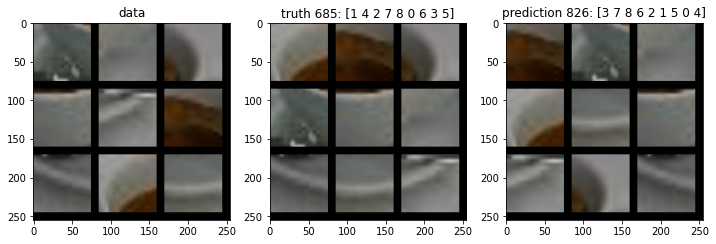

In [ ]:
args = easydict.EasyDict({'data': 'gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/',
          'model':None,
          'classes':1000,
          'gpu' : 1,
          'epochs' : 1,
          'iter_start' : 0,
          'batch' : 100,
          'lr' : 0.01,
          'cores' : 0,
          'checkpoint' : 'ss',  
          'evaluate' : 0
          })


criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()

trainpath =  'train/n07920052/images'
txtpath = 'train/n07920052/n07920052_boxes.txt'

valpath = 'train/n09256479/images'
val_txtpath = '/train/n09256479/n09256479_boxes.txt'

# Network initialize

net = Network(args.classes)
if args.gpu is not None:
  net.cuda()

optimizer = torch.optim.SGD(net.parameters(),lr=args.lr,momentum=0.9,weight_decay = 5e-4)

iter_per_epoch = 1
train_data = DataLoader(args.data + trainpath,args.data + txtpath,
                      classes=args.classes) 

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                      batch_size=args.batch,
                      shuffle=True,
                      num_workers=args.cores)

for epoch in range(int(args.iter_start/iter_per_epoch),args.epochs):
    
    if epoch %30 == 0:
      lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.6)

    for i, (data, true_index, original) in enumerate(train_loader):

      
      one_image = data
      one_label = true_index
      one_truth = original


 
      
      end = time()

      images = one_image.clone()
      labels = one_label.clone()


      plt.suptitle('Overall Title')
      plt.show()

      batch_time.append(time()-end)
      if len(batch_time)>100:
          del batch_time[0]
      images = Variable(torch.tensor(images))
      labels = Variable(torch.tensor(labels))
      if args.gpu is not None:
          images = images.cuda()
          labels = labels.cuda()

      # Forward + Backward + Optimize
      optimizer.zero_grad()
      t = time()
      outputs = net(images.view(-1,9,3,75,75))
      net_time.append(time()-t)
      if len(net_time)>100:
          del net_time[0]

      prec1, prec5 = compute_accuracy(outputs.cpu().data, labels.cpu().data, topk=(1, 5))

      acc = prec1.item()

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()
      loss = float(loss.cpu().data.numpy())
 

      if steps%4==0:
          print(('[%2d/%2d] %5d) [batch load % 2.3fsec, net %1.2fsec], LR %.5f, Loss: % 1.3f, Accuracy % 2.2f%%' %(
                      epoch+1, args.epochs, steps, 
                      np.mean(batch_time), np.mean(net_time),
                      lr, loss,acc)))

      # if steps%20==0:
      #     logger.scalar_summary('accuracy', acc, steps)
      #     logger.scalar_summary('loss', loss, steps)
          
      #     original = [im[0] for im in original]
      #     imgs = np.zeros([9,75,75,3])
      #     for ti, img in enumerate(original):
      #         img = img.numpy()
      #         imgs[ti] = np.stack([(im-im.min())/(im.max()-im.min()) 
      #                               for im in img],axis=2)
          
          #logger.image_summary('input', imgs, steps)

      steps += 1
  
      if steps%1000==0:
          filename = '%s/jps_%03i_%06d.pth.tar'%(args.checkpoint,epoch,steps)
          net.save(filename)
          print('Saved: '+args.checkpoint)
      
      end = time()
    visualization(images[0].cpu(),perms,labels[0].detach().cpu(),outputs[0].argmax())


In [ ]:
net

Network(
  (conv): Sequential(
    (conv1_s1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
    (relu1_s1): ReLU(inplace=True)
    (pool1_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv2_s1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2_s1): ReLU(inplace=True)
    (pool2_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn2_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv3_s1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_s1): ReLU(inplace=True)
    (conv4_s1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4_s1): ReLU(inplace=True)
    (conv5_s1): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (

# Train with JigResnet

## JigResnet

In [ ]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

import sys

import torchvision.models as models




class JigResnet(nn.Module):

    def __init__(self, classes=1000):
        super(JigResnet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet50 = models.resnet50(pretrained=True)

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*3*3, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1000,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))
        torch.nn.init.xavier_uniform(self.fc7.fc7.weight)
        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        torch.nn.init.xavier_uniform(self.classifier.fc8.weight)
        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)
    
    def forward(self, x):
        #print(x.size())
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.resnet50(x[i])
            #z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal(model.weight.data)
        nn.init.constant(model.bias.data, 0.1)
    


## JigResnet Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Top 5 accuracy 1.0
[ 1/ 1]     0) [batch load  0.017sec, net 0.16sec], LR 0.01000, Loss:  14.141, Accuracy  0.00%


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Top 5 accuracy 1.0
[ 1/ 1]     4) [batch load  0.017sec, net 0.10sec], LR 0.01000, Loss:  9.564, Accuracy  0.00%


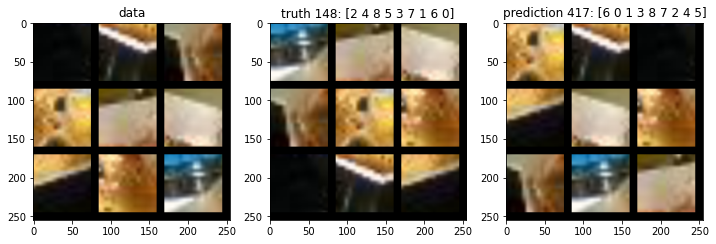

In [ ]:
args = easydict.EasyDict({'data': 'gdrive/MyDrive/Colab Notebooks/deep learning/final/small-tiny-imagenet-200/',
          'model':None,
          'classes':1000,
          'gpu' : 1,
          'epochs' : 1,
          'iter_start' : 0,
          'batch' : 100,
          'lr' : 0.01,
          'cores' : 0,
          'checkpoint' : 'ss',  
          'evaluate' : 0
          })


model = JigResnet()
if args.gpu is not None:
    model.cuda()


criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()

trainpath =  'train/n07920052/images'
txtpath = 'train/n07920052/n07920052_boxes.txt'

valpath = 'train/n09256479/images'
val_txtpath = '/train/n09256479/n09256479_boxes.txt'

batch_time, net_time = [], []
optimizer = torch.optim.SGD(model.parameters(),lr=args.lr,momentum=0.9,weight_decay = 5e-4)

iter_per_epoch = 1
train_data = DataLoader(args.data + trainpath,args.data + txtpath,
                      classes=args.classes) 

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                      batch_size=args.batch,
                      shuffle=True,
                      num_workers=args.cores)
losses = np.zeros(int(args.epochs*(len(train_data)/args.batch)))
steps = 0
lr = args.lr
for epoch in range(int(args.iter_start/iter_per_epoch),args.epochs):
    if epoch % 10 == 0 and epoch != 0:
      lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=10, decay=0.1)

    for i, (data, true_index, original) in enumerate(train_loader):

      
      one_image = data
      one_label = true_index
      one_truth = original


 
      
      end = time()

      images = one_image.clone()
      labels = one_label.clone()


      plt.suptitle('Overall Title')
      plt.show()

      batch_time.append(time()-end)
      if len(batch_time)>100:
          del batch_time[0]
      images = Variable(torch.tensor(images))
      labels = Variable(torch.tensor(labels))
      if args.gpu is not None:
          images = images.cuda()
          labels = labels.cuda()

      # Forward + Backward + Optimize
      optimizer.zero_grad()
      t = time()
      #print(images.size())
      outputs = model(images)
      net_time.append(time()-t)
      if len(net_time)>100:
          del net_time[0]

      prec1, prec5 = compute_accuracy(outputs.cpu().data, labels.cpu().data, topk=(1, 5))

      acc = prec1.item()

      loss = criterion(outputs, labels)
      losses[steps] = loss.item()

      loss.backward()
      optimizer.step()
      loss = float(loss.cpu().data.numpy())
 

      if steps%4==0:
          print('Top 5 accuracy {}'.format(prec5.item()))
          print(('[%2d/%2d] %5d) [batch load % 2.3fsec, net %1.2fsec], LR %.5f, Loss: % 1.3f, Accuracy % 2.2f%%' %(
                      epoch+1, args.epochs, steps, 
                      np.mean(batch_time), np.mean(net_time),
                      lr, loss,acc)))



      steps += 1
  
 
      
      end = time()
    visualization(images[0].cpu(),perms,labels[0].detach().cpu(),outputs[0].argmax())


In [ ]:
#torch.save(model.state_dict(), os.path.join('gdrive/MyDrive', 'JigResnet18'))

In [ ]:
#visualization(images[0].cpu(),perms,labels[0].detach().cpu(),outputs[0].argmax())

# Train with one image

In [ ]:
# load data
for i, (data, true_index, original) in enumerate(train_loader):
  print(i)
  print(data.shape)
  print(true_index)
  print((original[0]).shape)
  #plt.imshow(np.transpose(image, (1, 2, 0)))

  break

0
torch.Size([100, 9, 3, 75, 75])
tensor([899, 447, 973, 659, 302, 192, 906, 132, 730, 431, 380, 308, 457,  98,
        608, 717, 584, 408, 798, 166, 696, 932, 141, 181, 155, 924, 747, 461,
        481, 807, 468, 444, 411, 233, 825, 550, 142, 886,  54, 928, 548, 863,
        764, 958, 830, 598, 386,   6, 698, 711, 533, 229, 228, 841, 704, 243,
        655, 315, 467, 277, 601, 883, 627,  83, 229, 980, 663, 352, 387, 996,
         40, 371, 479, 728, 395, 522,  84, 830, 686, 995, 923, 311, 346, 122,
        365, 692, 243, 416, 122, 414, 477, 348, 843, 547, 858, 971, 329, 670,
        790, 500])
torch.Size([100, 3, 75, 75])


In [ ]:

net = JigResnet()
if args.gpu is not None:
    model.cuda()


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(),lr=args.lr,momentum=0.9,weight_decay = 5e-4)
args.epochs = 10
args.lr = 0.01
iter_per_epoch = 1

train_data = DataLoader(args.data + trainpath,args.data + txtpath,
                      classes=args.classes) 

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                      batch_size=args.batch,
                      shuffle=True,
                      num_workers=args.cores)

one_image = data[0]
one_label = true_index[0]
one_truth = original[:][0]
for epoch in range(int(args.iter_start/iter_per_epoch),args.epochs):

    lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.1)
    
    end = time()

    images = one_image.clone()
    labels = one_label.clone()

    plt.suptitle('Overall Title')
    plt.show()

    batch_time.append(time()-end)
    if len(batch_time)>100:
        del batch_time[0]

    images = Variable(torch.tensor(images))
    labels = Variable(torch.tensor(labels))
    if args.gpu is not None:
        images = images.cuda()
        labels = labels.cuda()

    # Forward + Backward + Optimize
    optimizer.zero_grad()
    t = time()
    outputs = net(images.view(-1,9,3,75,75))
    net_time.append(time()-t)
    if len(net_time)>100:
        del net_time[0]
    prec1, prec5 = compute_accuracy(outputs.cpu().data, labels.view(1,1).cpu().data, topk=(1, 5))
    acc = prec1.item()
    loss = criterion(outputs, labels.view(1))
    loss.backward()
    optimizer.step()
    loss = float(loss.cpu().data.numpy())
    print(images.cpu().shape,labels.detach().cpu().shape,outputs.detach().cpu().shape)
    visualization(images.cpu(),perms,labels.detach().cpu(),outputs.argmax())

    if steps%4==0:
        print(('[%2d/%2d] %5d) [batch load % 2.3fsec, net %1.2fsec], LR %.5f, Loss: % 1.3f, Accuracy % 2.2f%%' %(
                    epoch+1, args.epochs, steps, 
                    np.mean(batch_time), np.mean(net_time),
                    lr, loss,acc)))


    steps += 1

    if steps%1000==0:
        filename = '%s/jps_%03i_%06d.pth.tar'%(args.checkpoint,epoch,steps)
        net.save(filename)
        print('Saved: '+args.checkpoint)
    
    end = time()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Learning Rate 0.010000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: ignored